<a href="https://colab.research.google.com/github/RogerUltimate/-Keras-study/blob/main/8_3_code_neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural style transfer

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2016/01/11<br>
**Last modified:** 2020/05/02<br>
**Description:** Transfering the style of a reference image to target image using gradient descent.

## Introduction

Style transfer consists in generating an image
with the same "content" as a base image, but with the
"style" of a different picture (typically artistic).
This is achieved through the optimization of a loss function
that has 3 components: "style loss", "content loss",
and "total variation loss":

스타일 전이는 원본 이미지(base image)의 내용(content)을 유지하면서 다른 이미지의 스타일을 지니는 새로운 이미지를 만들어냅니다. 이렇게 하기 위해서 3개 요소로 구성된 손실 함수를 최적화합니다: 스타일 손실, 내용 손실, 총 변위 손실

※ 이 코드에서 용어 번역은 다음과 같이 하겠습니다

base image: 원본 이미지

style reference image: 스타일 이미지

combination image: 결합 이미지

- The total variation loss imposes local spatial continuity between
the pixels of the combination image, giving it visual coherence.

- 총 변위 손실은 결합 이미지의 픽셀들이 서로 공간적 연속성을 갖게 만듭니다 (바로 옆에 붙어 있는 픽셀들이 서로 너무 다르지 않게 하여 이미지가 전반적으로 부드럽게 느껴지는 효과를 냄)

- The style loss is where the deep learning keeps in --that one is defined
using a deep convolutional neural network. Precisely, it consists in a sum of
L2 distances between the Gram matrices of the representations of
the base image and the style reference image, extracted from
different layers of a convnet (trained on ImageNet). The general idea
is to capture color/texture information at different spatial
scales (fairly large scales --defined by the depth of the layer considered).

- 스타일 손실은 CNN을 사용합니다. 원본 이미지와 스타일 이미지 각각의 representation의 Gram 매트릭스들 간의 L2 거리를 더합니다. 이 representation은 (ImageNet에서 학습된) convnet의 서로 다른 레이어들에서 뽑아냅니다. 서로 다른 공간적 크기를 갖는 레이어들에서 색상/재질 정보를 잡아오는 것입니다.

- The content loss is a L2 distance between the features of the base
image (extracted from a deep layer) and the features of the combination image,
keeping the generated image close enough to the original one.

- 내용 손실은 원본 이미지의 특성과 결합 이미지의 특성 사이의 L2 거리입니다. 생성된 이미지를 원본 이미지와 비슷하게 유지하는 역할을 합니다.

**Reference:** [A Neural Algorithm of Artistic Style](
  http://arxiv.org/abs/1508.06576)


## Setup


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg"
)
result_prefix = "paris_generated"

# Weights of the different loss components
# 각각의 loss에 얼마만큼의 가중치를 줄 것인지 설정함 (가중치를 어떻게 설정할지는 'art'의 영역)
# <창시자> 책에서는 각각 1e-4, 1, 0.025였음
# content_weight을 크게 하면 원본 이미지의 'content'가 더 많이(강하게) 남아 있게 됨
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
# 결합 이미지의 행 숫자를 400으로 하고 가로세로 비율은 원본 이미지와 같게 함
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)


942080/935806 [==============================] - 0s 0us/step


## Let's take a look at our base (content) image and our style reference image


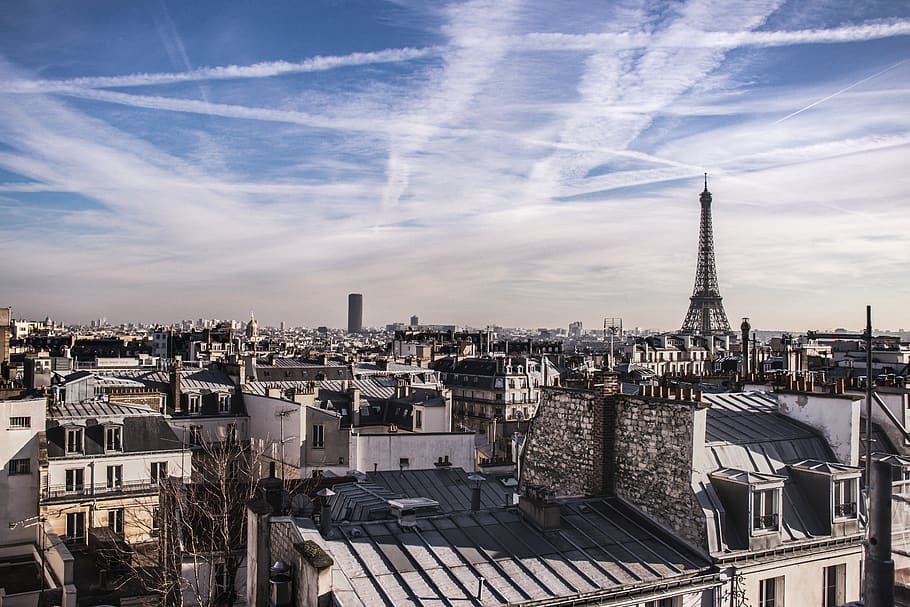

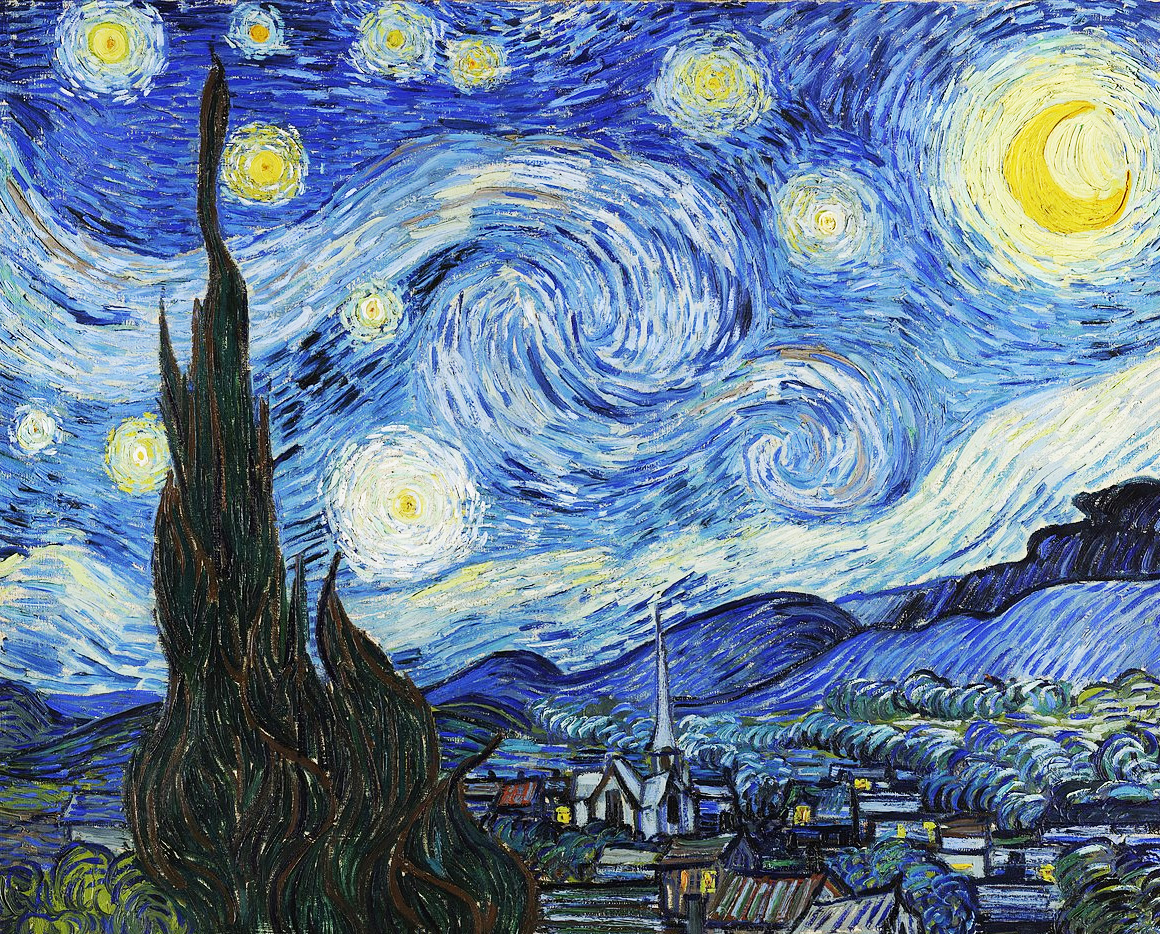

In [ ]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

## Image preprocessing / deprocessing utilities


In [ ]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    # 이미지를 열고, 크기를 바꾸고, 형식을 갖추어서 적절한 텐서로 만드는 유틸리티 함수
    # 원본 이미지, 스타일 이미지, 결과 이미지 모두 이 함수로 전처리함
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)    # 앞서 정의한 결과 이미지의 행, 열 크기인 (400, 599)
    )
    img = keras.preprocessing.image.img_to_array(img)     # array(숫자)로 바꿈. (400, 599, 3)이 됨
    img = np.expand_dims(img, axis=0)                     # 앞에 차원을 하나 추가. 배치 차원이 있어야 VGG19에 입력으로 넣을 수 있음.(1, 400, 599, 3)
    img = vgg19.preprocess_input(img)                     # VGG19 입력을 위해 이미지를 전처리하는 함수. shape은 (1, 400, 599, 3) 그대로임
    return tf.convert_to_tensor(img)                      # 텐서로 바꾸어 돌려줌. (1, 400, 599, 3) 그대로
    # vgg19.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel 
    # with respect to the ImageNet dataset, without scaling.
    # vgg19.preprocess_input은 RGB --> BRG로 바꾸고
    # 각 채널 데이터별로 0값이 중앙에 오게 바꿈. 크기는 바꾸지 않음


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    # 텐서를 유효한 이미지로 변환하는 유틸리티 함수.
    # 위에서 vgg19.preprocess_input이 했던 일들을 되돌림
    # 학습 전에는 vgg19.preprocss_input으로 처리하여 텐서로 만들어 학습을 시키고, 
    # 학습이 끝나면 시각화가 가능한 이미지로 되돌리는 것
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel 픽셀 평균을 더해줌으로써 0값이 중앙에 오게 했던 것을 되돌림
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    # uint8: 8-bit unsigned integer. 8 비트(따라서 표현 가능한 값의 범위는 [0, 255])이며 양의 값을 갖는 정수
    # 여기서 'sign'은 (-) 부호를 말하며, 따라서 'unsigned'는 (-)부호가 붙지 않는다, 양수이다 라는 의미
    x = np.clip(x, 0, 255).astype("uint8")    # 0보다 작은 값은 0으로 바꾸고, 255보다 큰 값은 255로 바꿈
    return x



## Compute the style transfer loss

First, we need to define 4 utility functions:

- `gram_matrix` (used to compute the style loss)
- The `style_loss` function, which keeps the generated image close to the local textures
of the style reference image
- The `content_loss` function, which keeps the high-level representation of the
generated image close to that of the base image
- The `total_variation_loss` function, a regularization loss which keeps the generated
image locally-coherent


In [ ]:
# The gram matrix of an image tensor (feature-wise outer product)
# 이미지 텐서의 Gram 매트릭스 (특성의 외적)
# Gram 매트릭스에는 이미지가 아니라 이미지 feature들이 입력됨(스타일 이미지, 결과 이미지 각각의)

def gram_matrix(x):                                          # 예시
    x = tf.transpose(x, (2, 0, 1))                           # (400, 599, 3) --> (3, 400, 599). 채널이 앞으로 옴
    features = tf.reshape(x, (tf.shape(x)[0], -1))           # (3, 400*599). shape(x)[0]은 그냥 두고 나머지는 알아서 맞추라는 뜻
    gram = tf.matmul(features, tf.transpose(features))       # (3, 400*599) x (400*599, 3) = (3, 3). 최종적으로 (채널, 채널)만 남음
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
# '스타일 손실'은 스타일 이미지의 스타일이 결과 이미지에 옮겨지게 하는 역할을 합니다.
# 스타일 이미지와 결과 이미지의 특성맵(feature map)의 스타일을 잡아오는 Gram 매트릭스를
# 이용하여 이런 일을 합니다.

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    # reduce_sum은 axis를 정해주면 그 axis의 element들을 합계함 --> 그 axis가 소멸됨
    # axis를 정해주지 않으면 전체를 합계함 --> 숫자 하나만 return함
    # (S - C)를 제곱하는 것은 L2 거리이기 때문임
    # 4.0을 곱해주고(2의 제곱?) channels와 size를 제곱하는 이유는 잘 모르겠음
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))   # 역시 L2 거리이기 때문에 제곱함


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    # 끝 열은 제외. 마지막 행을 제외한 덩어리와 첫 행을 제외한 덩어리를 (-)
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    # 끝 행은 제외. 마지막 열을 제외한 덩어리와 첫 열을 제외한 덩어리를 (-)
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))     # 1.25승(왜?)


Next, let's create a feature extraction model that retrieves the intermediate activations
of VGG19 (as a dict, by name).


In [ ]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
# vgg19 모델의 각 레이어를 이용하여 {레이어 이름: 레이어 output}로 딕셔너리를 만듬
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
# vgg19의 모든 레이어의 활성화 값을 반환(return)하는 모델을 만듬. 이름은 'feature extractor(특성 추출기)'
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80142336/80134624 [==============================] - 1s 0us/step


Finally, here's the code that computes the style transfer loss.


In [ ]:
# List of layers to use for the style loss.
# 스타일 loss는 다음의 레이어들에 대해서 계산함(각 블록의 첫번째 레이어)
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
# 컨텐트 loss는 다음 하나의 레이어에 대해서만 계산함
content_layer_name = "block5_conv2"

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0    # 3개의 이미지를 합침(아래에 연달아 붙임)
    )
    features = feature_extractor(input_tensor)   # 3개를 합친 입력값에 대한 특성 추출 결과값

    # Initialize the loss
    loss = tf.zeros(shape=())       # shape을 정의하지 않고 만듬

    # Add content loss
    layer_features = features[content_layer_name]       # block5_conv2의 특성 추출값
    base_image_features = layer_features[0, :, :, :]     # 0번째는 원본 이미지의 특성
                                                         # 위에서 이미지들을 concatenate했음에도 불구하고
                                                         # 0번째라는 순서가 살아 있는 듯
    combination_features = layer_features[2, :, :, :]    # 2번째는 결과 이미지의 특성
    loss = loss + content_weight * content_loss(         # content_loss에 content_weight을 곱해줌
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]    # 1번째는 스타일 이미지의 특성
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl     # style_loss에 style_weight을 곱해줌
                                                                 # loss 변수에 모든 종류의 loss값이 다 쌓이고 있음

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)   # 총 변위 손실까지 더해서 loss값 완성
    return loss



## Add a tf.function decorator to loss & gradient computation

To compile it, and thus make it fast.

컴파일하고, 빠르게 만들기 위해서(tf.function decorator를 추가)


In [ ]:
# @는 장식자(decorator)로서 그 다음에 오는 함수를 감싸주면서(=wrapper의 일종) 새로운 기능도 추가
# 여기서 '새로운 기능'이라 함은 tf.function의 기능임.

# 참고로 wrapper에는 decorator도 있고, adapter도 있음
# 아래의 '@tf.function' 부분을
# 장식자를 사용하지 않고 그 다음에 오는 함수를 바로 인자로 넣어서 다음과 같이 쓸 수도 있음
# tf.function(compute_loss_and_grads(~~~))

# tf.function() 함수는 그 다음에 오는 compute_loss_and_grads() 함수를 인자로 받아서 Autograph라는 기능을 추가
# Autograph는 파이썬 문법으로서, 그래프(Graph)를 컨트롤할 수 있게 해줌. 
# 보다 구체적으로 설명하면,
# 여기서는 GradientTape이 계산에 관계되는 모든 변수와 연산을 추적하기 때문에 performance에 영향을 주는데,
# tf.function 장식자를 붙이면 이 연산들을 고성능의 그래프 연산으로 변환하기 때문에 performance를 개선할 수 있음

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:                     # GradientTape을 이용하여.......
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)      # 결과 이미지가 변화하면 loss가 어떻게 변하는지 기울기
    return loss, grads

# GradientTape에 대한 추가 설명

# 통상의 딥러닝 네트워크에서는 가중치를 학습시키는데, 지금 우리 코드에는 가중치가 존재하지 않고,
# 2개의 이미지와 그 Gram matrix의 차이만 존재. 이런 상황에서 학습을 시키기 위한 방법으로 사용하는 것이
# GradientTape임.

# 우선 tape이라는 이름으로 GradientTape의 인스턴스를 생성하고
# with 구문 안에서 발생하는 연산을 tape에 기록 (기록한다고 해서 이름이 tape임: 비디오 테입)
# tape.gradient(loss, combination_image)는 with 구문 안에서 발생한 loss 계산을 추적해서
# 입력값인 combination_image(결과 이미지)에 대한 loss의 gradient(기울기)를 계산함. 
# (즉, 입력값이 변화하면 loss가 어떻게 변화하는지를 알려주는 gradient를 계산함)
# 이렇게 계산된 gradient는 뒤에 나오는 코드에서 optimizer에 전달되어 
# combination_image(결과 이미지)를 원하는 방향으로 변화시키게 됨

# 출처: <텐서플로 2.0 프로그래밍> 위키북스 pp.309, 312~313

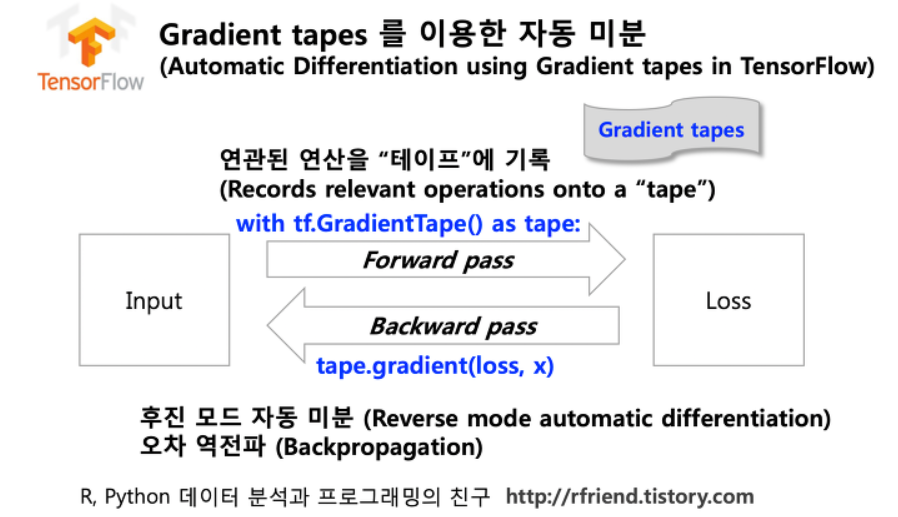

## The training loop

Repeatedly run vanilla gradient descent steps to minimize the loss, and save the
resulting image every 100 iterations.

We decay the learning rate by 0.96 every 100 steps.

스텝 100개마다 학습률에 0.96을 곱해줌(ExponentialDecay)


In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path) 
combination_image = tf.Variable(preprocess_image(base_image_path))   # 원본 이미지와 스타일 이미지는 바뀌지 않으나
                                                                     # 결합 이미지는 내용이 계속 바뀌니 변수로 지정
iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])   # optimizer에 gradient를 적용(apply)시킴
    if i % 100 == 0:                                          # 매 100번째 iteration마다 결과 이미지를 deprocess하여 저장
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)


Iteration 100: loss=11018.08
Iteration 200: loss=8513.94
Iteration 300: loss=7571.53
Iteration 400: loss=7063.91
Iteration 500: loss=6736.22
Iteration 600: loss=6501.58
Iteration 700: loss=6323.08
Iteration 800: loss=6181.20
Iteration 900: loss=6065.15
Iteration 1000: loss=5967.49
Iteration 1100: loss=5884.24
Iteration 1200: loss=5812.55
Iteration 1300: loss=5750.27
Iteration 1400: loss=5695.65
Iteration 1500: loss=5647.32
Iteration 1600: loss=5604.34
Iteration 1700: loss=5565.81
Iteration 1800: loss=5531.10
Iteration 1900: loss=5499.66
Iteration 2000: loss=5471.01
Iteration 2100: loss=5444.89
Iteration 2200: loss=5421.02
Iteration 2300: loss=5399.14
Iteration 2400: loss=5378.92
Iteration 2500: loss=5360.22
Iteration 2600: loss=5342.94
Iteration 2700: loss=5326.96
Iteration 2800: loss=5312.17
Iteration 2900: loss=5298.39
Iteration 3000: loss=5285.56
Iteration 3100: loss=5273.58
Iteration 3200: loss=5262.39
Iteration 3300: loss=5251.92
Iteration 3400: loss=5242.09
Iteration 3500: loss=5

After 4000 iterations, you get the following result:


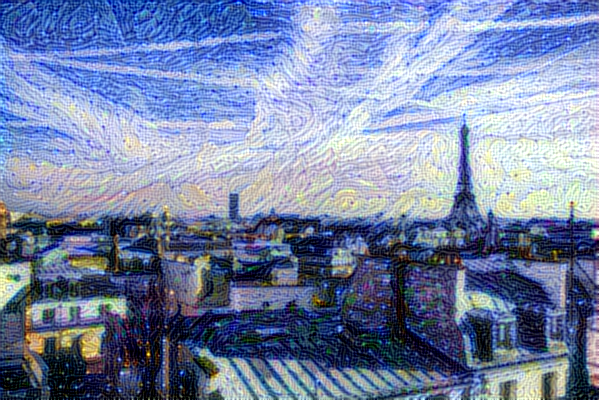

In [ ]:
display(Image(result_prefix + "_at_iteration_4000.png"))
